In [1]:
import sys
sys.path.append('..')

import datasets.dcase_few_shot_bioacoustic as util
import datasets.feature_extract as fe

from glob import glob
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import h5py 
import librosa
import numpy as np
from sklearn.model_selection import KFold
import torch.utils.data as data
import torch
from collections import defaultdict
import datasets.randomepisode as re

In [2]:
class ConfigDummy():
    
    def __init__(self):
        self.features = Features()
        self.train = Train()
        self.path = Path()
        self.datagen = Datagen()
        
class Features():
    
    def __init__(self):
        self.sr = 22050
        self.seg_len = 0.2
        self.hop_seg = 0.05
        self.n_fft = 1024
        self.hop_mel = 256
        self.n_mels = 128
        self.fmax = 11025
        self.tile_train = True
        
class Train():
    
    def __init__(self):
        self.n_shot = 5
        self.k_way = 10
        self.n_query = 5
        self.sample_threshold = 15
        self.folds = 5
        self.semi_test_path = '/home/willbo/data/dcase/features/hfiles/test'
        self.semi_k_way = 5
        self.semi_use_train = True
        self.semi_use_val = True
        self.semi_use_test = True
        
class Path():
    
    def __init__(self):
        self.features = 'TrainValCV'
        
class Datagen():
    
    def __init__(self):
        self.ltoi = True
        self.balance = True
        self.normalize = True

In [3]:
config = ConfigDummy()
spectralizer = fe.Spectralizer(config)

In [4]:
train_path = '/home/willbo/data/dcase/train'
val_path = '/home/willbo/data/dcase/val'

train_csv = [file for file in glob(os.path.join(train_path, '*.csv'))]
val_csv = [file for file in glob(os.path.join(val_path, '*.csv'))]
all_csv = train_csv + val_csv

### Basis
Constructing of a class dict which the whole procedure will be built on.

In [5]:
df = pd.read_csv(all_csv[0])
print(df.columns)
print(df.columns[3+2])

Index(['Audiofilename', 'Starttime', 'Endtime', 'GRN', 'GIG', 'SQT'], dtype='object')
SQT


In [5]:
CLS_START_INDEX = 3

class_map = defaultdict(list)
class_dict = {}

'''
TODO: Fuck me, this way of doing things will not work since some of the classes in the training set appears in multiple files.
      How to solve this issue and keep the structure. I see no real problem with having file_path being a list.
      What else needs doing? How does this change the feature extraction? Mostly in the way of keys.
      Need to change class keys to what they are in the annotation columns in the training files.
      Keep keys for validatoin files since they all are labeled Q.
      Might wanna switch over to default dicts here and append to lists.
      Then we can just use column names as keys.
      
      Alternatively keep all as is and complement the dict with another key with a structure over which tags belong to the same class.
      This might be the fastest/easiest fix for this since we can keep the rest as is.
      Use hashmap to start?
      
      The alternative is probably tricker down the line when it comes to the folds actually, might not be doable.
      We are at a crossroads here when it comes to trainset/folds/few-shot eval.
'''

for csv_file in train_csv:
    
    df = pd.read_csv(csv_file)
    num_classes = len(df.columns[3:])
    
    for i in range(num_classes):
        
        class_name = csv_file.split('/')[-1].split('.')[0]+'_'+str(i)
        class_map[df.columns[CLS_START_INDEX+i]].append(class_name)
        cols = list(range(CLS_START_INDEX)) + [i+CLS_START_INDEX]
        sub_df = df.iloc[:, cols]
        sub_df_POS = sub_df[(sub_df == 'POS').any(axis=1)]
        starttime_pos = sub_df_POS['Starttime'].values
        endtime_pos = sub_df_POS['Endtime'].values
        sub_df_UNK = sub_df[(sub_df == 'UNK').any(axis=1)]
        starttime_unk = sub_df_UNK['Starttime'].values
        endtime_unk = sub_df_UNK['Endtime'].values
        
        '''
        if len(starttime_pos) >= config.train.sample_threshold:
            class_dict[class_name] = {'file_path': csv_file, 'start_pos' : starttime_pos, 'end_pos' : endtime_pos, 'start_unk' : starttime_unk, 'end_unk' : endtime_unk}
        '''
        class_dict[class_name] = {'file_path': csv_file, 'start_pos' : starttime_pos, 'end_pos' : endtime_pos, 'start_unk' : starttime_unk, 'end_unk' : endtime_unk}
        
for csv_file in val_csv:
    
    df = pd.read_csv(csv_file)
    num_classes = len(df.columns[3:])
    
    for i in range(num_classes):
        
        class_name = csv_file.split('/')[-1].split('.')[0]+'_'+str(i)
        class_map[class_name].append(class_name)
        cols = list(range(CLS_START_INDEX)) + [i+CLS_START_INDEX]
        sub_df = df.iloc[:, cols]
        sub_df_POS = sub_df[(sub_df == 'POS').any(axis=1)]
        starttime_pos = sub_df_POS['Starttime'].values
        endtime_pos = sub_df_POS['Endtime'].values
        sub_df_UNK = sub_df[(sub_df == 'UNK').any(axis=1)]
        starttime_unk = sub_df_UNK['Starttime'].values
        endtime_unk = sub_df_UNK['Endtime'].values
        
        '''
        if len(starttime_pos) >= config.train.sample_threshold:
            class_dict[class_name] = {'file_path': csv_file, 'start_pos' : starttime_pos, 'end_pos' : endtime_pos, 'start_unk' : starttime_unk, 'end_unk' : endtime_unk}
        '''
        class_dict[class_name] = {'file_path': csv_file, 'start_pos' : starttime_pos, 'end_pos' : endtime_pos, 'start_unk' : starttime_unk, 'end_unk' : endtime_unk}

In [7]:
print(class_map)
print(len(list(class_map.keys())))

defaultdict(<class 'list'>, {'GRN': ['y1_0', 'e1_0', 'h1_0'], 'GIG': ['y1_1', 'e1_1', 'h1_1'], 'SQT': ['y1_2', 'e1_2', 'h1_2'], 'SNMK': ['dcase_MK1_0', 'dcase_MK2_0'], 'CCMK': ['dcase_MK1_1', 'dcase_MK2_1'], 'AGGM': ['dcase_MK1_2', 'dcase_MK2_2'], 'SOCM': ['dcase_MK1_3', 'dcase_MK2_3'], 'AMRE': ['2015-09-21_06-00-00_unit05_0', '2015-09-04_08-04-59_unit03_0', '2015-09-11_06-00-00_unit07_0'], 'BBWA': ['2015-09-21_06-00-00_unit05_1', '2015-09-04_08-04-59_unit03_1'], 'BTBW': ['2015-09-21_06-00-00_unit05_2', '2015-09-25_04-00-00_unit10_0', '2015-09-04_08-04-59_unit03_2'], 'COYE': ['2015-09-21_06-00-00_unit05_3', '2015-09-25_04-00-00_unit10_2', '2015-09-04_08-04-59_unit03_3', '2015-09-11_06-00-00_unit07_1'], 'GCTH': ['2015-09-21_06-00-00_unit05_4', '2015-09-25_04-00-00_unit10_3', '2015-10-14_23-59-59_unit05_1', '2015-09-11_06-00-00_unit07_2'], 'OVEN': ['2015-09-21_06-00-00_unit05_5', '2015-09-25_04-00-00_unit10_4', '2015-09-04_08-04-59_unit03_4', '2015-09-11_06-00-00_unit07_3'], 'RBGR': ['20

In [8]:
class_dict[list(class_dict.keys())[0]]['end_pos']

array([1214.22, 1217.09, 1219.5 , 1221.77, 1224.58, 1233.73, 1239.62,
       1242.08, 1242.84, 1267.29, 1294.29, 1302.74, 1312.4 , 1708.53,
       1711.96, 1716.  , 1793.54, 1807.4 , 1814.99, 1816.57, 1822.28,
       1830.22, 1843.05, 1847.96, 1851.23, 1854.23, 1858.19, 1862.43,
       1867.22, 1883.54, 1896.07, 1904.37])

In [9]:
#dict creation validation / statistics

num_pos_sample_per_class_stat = []

print('Total number of classes: '+str(len(list(class_dict.keys()))))
for key in class_dict:
    print('Class: '+key)
    print('File: '+class_dict[key]['file_path'])
    s_time_pos = class_dict[key]['start_pos']
    e_time_pos = class_dict[key]['end_pos']
    s_time_unk = class_dict[key]['start_unk']
    e_time_unk = class_dict[key]['end_unk']
    print('Events shorter than 0s: '+str(((e_time_pos-s_time_pos) < 0).any() or ((e_time_unk-s_time_unk) < 0).any()))
    print('Number of positive annotated events: '+str(len(s_time_pos)))
    num_pos_sample_per_class_stat.append(len(s_time_pos))
    print('Number of unkown annotated events: '+str(len(s_time_unk)))

Total number of classes: 61
Class: y1_0
File: /home/willbo/data/dcase/train/y1.csv
Events shorter than 0s: False
Number of positive annotated events: 32
Number of unkown annotated events: 11
Class: y1_1
File: /home/willbo/data/dcase/train/y1.csv
Events shorter than 0s: False
Number of positive annotated events: 20
Number of unkown annotated events: 12
Class: y1_2
File: /home/willbo/data/dcase/train/y1.csv
Events shorter than 0s: False
Number of positive annotated events: 15
Number of unkown annotated events: 12
Class: dcase_MK1_0
File: /home/willbo/data/dcase/train/dcase_MK1.csv
Events shorter than 0s: False
Number of positive annotated events: 32
Number of unkown annotated events: 17
Class: dcase_MK1_1
File: /home/willbo/data/dcase/train/dcase_MK1.csv
Events shorter than 0s: False
Number of positive annotated events: 290
Number of unkown annotated events: 23
Class: dcase_MK1_2
File: /home/willbo/data/dcase/train/dcase_MK1.csv
Events shorter than 0s: False
Number of positive annotated 

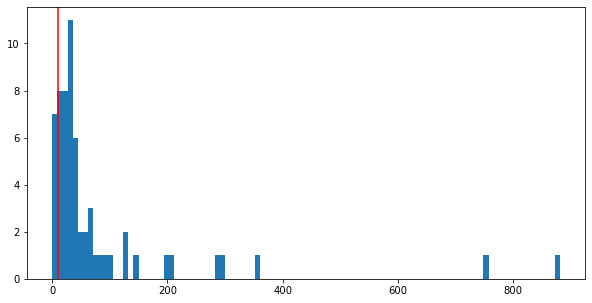

In [10]:
plt.figure(figsize=(10,5))
plt.hist(num_pos_sample_per_class_stat, bins=100)
plt.axvline(x=10, color='red')

Considering the above some classes need to be cut from the dataset. Possible threshold ~15samples or the like.

### Feature extraction

In [6]:

'''
TODO: Fix such that a class from a file with less than n_shot samples doesn't get a few-shot set or an empty set.
      Anyhow, depends on how this is solved. Just dont create one and don't go look for it based on the dict most likely.
'''

#Don't forget to think about input to this function such the class dict/config, possibly make this a class aswell.
def extract_TrainValCV():

    '''
    Preliminary structure.
    h5 structure:

        audiofile_name.h5py
            'all' : pcen patches of whole audio file.
            per class
            'class_name_pos' : all pcen patches of annotated segments of audio (used for training, use keys as labels in datagen)
            'class_name_pos_fs' : pcen patches of n-shot event segments (used for evaluation)
            'class_name_query_start_index' : index of first query patch (in dataset negative, used for evaluation)
            note: with this index and the set negative one can create a set query which can be used in current code base
    '''

    #How to smoothly transition from paths to files + class_dict in to a feature extraction with output as the structure desribed above?
    #It dosn't need to be pretty. We can just go per file I suppose, check in the dict which classes belongs to that file and go.

    output_path = 'TrainValCV'

    fps = config.features.sr / config.features.hop_mel
    seg_len = int(round(config.features.seg_len * fps))
    hop_seg = int(round(config.features.hop_seg * fps))

    for file in all_csv:

        print('Processing ' + file.replace('csv', 'wav'))
        file_name = file.split('/')[-1].replace('.csv', '.h5')

        classes_in_file = []
        for key in class_dict:
            if class_dict[key]['file_path'] == file:
                classes_in_file.append(key)

        h5_file = h5py.File(os.path.join(output_path, file_name), 'w')

        # --- Extraction ---

        audio, sr = librosa.load(file.replace('csv', 'wav'), config.features.sr)
        #print('Spectral transform')
        pcen = spectralizer.raw_to_spec(audio, config)

        h5_file.create_dataset('all',shape=(0, seg_len, config.features.n_mels), maxshape=(None, seg_len, config.features.n_mels))

        strt_index = 0
        idx_neg = 0
        end_idx_neg = pcen.shape[0]-1
        hop_neg = 0

        while end_idx_neg - (strt_index + hop_neg) > seg_len:
            patch_neg = pcen[int(strt_index + hop_neg):int(strt_index + hop_neg + seg_len)]
            h5_file['all'].resize((idx_neg + 1, patch_neg.shape[0], patch_neg.shape[1]))
            h5_file['all'][idx_neg] = patch_neg
            idx_neg += 1
            hop_neg += hop_seg

        last_patch = pcen[end_idx_neg - seg_len:end_idx_neg]
        h5_file['all'].resize((idx_neg + 1, last_patch.shape[0], last_patch.shape[1]))
        h5_file['all'][idx_neg] = last_patch

        h5_file.create_dataset('mean_global',shape=(1,), maxshape=(None))
        h5_file.create_dataset('std_global',shape=(1,), maxshape=(None))
        h5_file['mean_global'][:] = np.mean(pcen)
        h5_file['std_global'][:] = np.std(pcen)

        print(classes_in_file)

        for c in classes_in_file:

            events = []
            events_n_shot = []

            start_time, end_time = util.time_2_frame(class_dict[c]['start_pos'], class_dict[c]['end_pos'], fps)
            print(start_time)
            print(end_time)
            num_samples = len(start_time)
            
            #See if we cant quickly fix start_query here.
            #In previous code the start_index_query was used to index the whole pcen from librosa.
            #We can use this to count right probably?
            #Maybe just divide by hop_seg

            for index in range(len(start_time)):

                str_ind = start_time[index]
                end_ind = end_time[index]

                #Event longer than a segment?
                if end_ind - str_ind > seg_len:
                    shift = 0
                    while end_ind - (str_ind + shift) > seg_len:

                        pcen_patch = pcen[int(str_ind + shift):int(str_ind + shift + seg_len)]
                        events += [pcen_patch]
                        if index < config.train.n_shot:
                            events_n_shot += [pcen_patch]
                        shift += hop_seg

                    pcen_patch = pcen[end_ind - seg_len:end_ind]
                    events += [pcen_patch]
                    if index < config.train.n_shot:
                            events_n_shot += [pcen_patch]

                #Event shorter than a segment!
                else:
                    #TODO: Introduce alternative to tiling.
                    if config.features.tile_train:
                        #Repeat the patch til segment length.
                        pcen_patch = pcen[str_ind:end_ind]
                        if pcen_patch.shape[0] == 0:
                            continue

                        repeats = int(seg_len/(pcen_patch.shape[0])) + 1
                        pcen_patch_new = np.tile(pcen_patch, (repeats, 1))
                        pcen_patch_new = pcen_patch_new[0:int(seg_len)]
                        events += [pcen_patch_new]
                        if index < config.train.n_shot:
                            events_n_shot += [pcen_patch_new]

                    else:

                        #extend segment from annotations until seg_len is reached.
                        #TODO: Fix potential out of bounds problems 
                        i = 0
                        while (end_ind + i) - (str_ind - i) < seg_len:
                            i+=1
                        pcen_patch = pcen[(str_ind - i):(end_ind + i)]
                        pcen_patch = pcen_patch[0:int(seg_len)]
                        if pcen_patch.shape[0] == 0:
                            print(pcen_patch.shape[0])
                            print("The patch is of 0 length (training)")
                            continue
                        events += [pcen_patch]
                        if index < config.train.n_shot:
                            events_n_shot += [pcen_patch]

            #Investigate shapes. Something is off.
            
            #TODO: Include a query here.
            if num_samples >= config.train.n_shot:
                strt_indx_query = end_time[config.train.n_shot-1]
                hop_query = 0
                q_segs = []
                while end_idx_neg - (strt_indx_query + hop_query) > seg_len:
                    patch_query = pcen[int(strt_indx_query + hop_query):int(strt_indx_query + hop_query + seg_len)]
                    hop_query += hop_seg
                    q_segs.append(patch_query)
                last_query = pcen[end_idx_neg - seg_len:end_idx_neg]
                q_segs.append(last_query)
                
            #APPEND EVENTS TO SET HERE           
            h5_file.create_dataset(c+'_pos', data=events)
            if num_samples >= config.train.n_shot:
                h5_file.create_dataset(c+'_pos_fs', data=events_n_shot)
                h5_file.create_dataset(c+'_query', data=q_segs)
                h5_file.create_dataset(c+'_start_index_query',shape=(1,),maxshape=(None))
                h5_file[c+'_start_index_query'][:] = end_time[config.train.n_shot-1]

        h5_file.close()

        # ------------------
    

In [7]:
extract_TrainValCV()

Processing /home/willbo/data/dcase/train/y1.wav
['y1_0', 'y1_1', 'y1_2']
[104504, 104707, 104928, 105122, 105320, 106166, 106439, 106885, 107005, 109059, 111156, 111568, 112520, 146968, 147252, 147603, 154259, 155534, 156132, 156370, 156775, 157496, 158590, 158955, 159294, 159555, 159903, 160195, 160675, 162104, 163153, 163824]
[104586, 104833, 105041, 105236, 105478, 106266, 106774, 106985, 107051, 109157, 111482, 112210, 113042, 147162, 147458, 147806, 154484, 155678, 156332, 156468, 156960, 157644, 158749, 159172, 159453, 159712, 160053, 160418, 160831, 162236, 163315, 164030]
[25657, 32015, 106905, 106995, 111143, 111654, 112045, 112684, 112946, 113078, 165419, 165816, 166585, 166735, 167523, 176471, 294645, 294715, 306825, 307208]
[25696, 32142, 106939, 107028, 111494, 111986, 112545, 112850, 112994, 113383, 165603, 165890, 166619, 166788, 167651, 176514, 294689, 294831, 307000, 307392]
[106485, 108054, 108490, 111060, 114551, 114679, 114805, 115172, 115277, 115509, 115824, 145541

[17548, 45802, 138159, 138325, 138804, 203211, 418287, 429389, 523975, 543081, 562652]
[17565, 45819, 138176, 138342, 138821, 203228, 418304, 429406, 523992, 543098, 562669]
[82552, 221614, 313700, 502781, 504855, 505390, 616979]
[82569, 221631, 313718, 502798, 504873, 505407, 616996]
[15677, 29879, 52419, 52585, 104959, 186731, 187201, 214357, 215797, 296431, 307022, 378500, 378644, 382720, 386619, 387726, 398864, 402466, 442050, 487849, 487924, 500644, 524171, 568145, 582426, 582703, 582941, 583434, 583506, 601219]
[15694, 29896, 52436, 52602, 104976, 186748, 187218, 214374, 215815, 296449, 307040, 378517, 378661, 382737, 386637, 387743, 398881, 402483, 442067, 487866, 487941, 500662, 524189, 568162, 582444, 582721, 582958, 583451, 583523, 601236]
[109282, 109864, 111185, 112086, 113655, 152325, 205176, 233081, 234540, 267132, 281730, 283294, 316111, 327835, 328745, 329344, 367096, 368727, 368899, 372525, 389438, 407236, 408373, 414405, 414779, 429658, 438824, 445411, 445678, 488647,

[76504, 144075, 337178, 425571, 426072, 426644, 427193, 514109, 514221, 514887, 517266]
[76521, 144092, 337195, 425588, 426090, 426661, 427211, 514127, 514239, 514904, 517284]
[4653, 10074, 13374, 14489, 19694, 34283, 69743, 70780, 71965, 90423, 99791, 152907, 165104, 165542, 174514, 198866, 199475, 201071, 202684, 216315, 217789, 224891, 230516, 233817, 284145, 288861, 289735, 297200, 297312, 298735, 298959, 299760, 299949, 300635, 317437, 321079, 408207, 422761, 471612]
[4671, 10092, 13391, 14507, 19711, 34300, 69760, 70797, 71983, 90440, 99808, 152924, 165121, 165559, 174531, 198884, 199493, 201089, 202701, 216332, 217806, 224909, 230533, 233834, 284163, 288878, 289752, 297217, 297329, 298753, 298976, 299778, 299966, 300652, 317454, 321097, 408224, 422778, 471629]
[3864, 100007, 105104, 111932, 129865, 144792, 146831, 148562, 149188, 160861, 161789, 161984, 164905, 202491, 246341, 336220, 396684, 415372, 416703, 450952, 458173, 588978, 591431]
[3881, 100025, 105121, 111949, 129882, 

['h1_0', 'h1_1', 'h1_2']
[140018, 140323, 141275, 141864, 142373, 142719, 147823, 150344, 151605, 153183, 153619, 155916, 167315, 171514, 171813, 172069, 172378, 172955, 174586, 190230, 191123, 193719, 195751, 195940, 199763, 200037, 219981, 219981, 220347, 220347, 221058, 221058, 241133, 241133, 241428, 241428, 241603, 241603, 241733, 241733, 244338, 244338, 250190, 250190, 252461, 252461, 252851, 252851, 253460, 253460, 254958, 254958, 255219, 255219, 255663, 255663, 256023, 256023, 256323, 256323, 256539, 256539, 256951, 256951, 257299, 257299, 257828, 257828, 258091, 258091, 258425, 258425, 258746, 258746, 259161, 259161, 259496, 259496, 260080, 260080, 260463, 260463, 260896, 260896, 261393, 261393, 263697, 263697, 264044, 264044, 271924, 271924, 273454, 273454, 279826, 279826, 285086, 285086, 285448, 285448, 285782, 285782, 286172, 286172, 286858, 286858, 287378, 287378, 290887, 290887, 296346, 296346, 296631, 296631, 297151, 297151, 297389, 297389, 297575, 297575, 297912, 297912

[137643, 138893, 139593, 140338, 170206, 216135, 216925, 218166, 227325, 227456, 229155, 281347, 319243, 321254, 456882, 475247, 476669, 477041, 477529, 478370, 478638, 478894, 479240, 480116, 480336, 480594, 480798, 481565, 482754, 484256, 485479, 494921, 511753, 512710, 513231, 513770, 514120, 514504, 514856, 515310, 520213, 542293, 545198, 547518, 551701, 562110, 564864, 566448, 567002, 567288, 567930, 568757, 572893, 573695, 573721, 574046, 574552, 575222, 575773, 576170, 576622, 577839, 578676, 579002, 579506, 603978]
[137660, 138910, 139610, 140355, 170223, 216152, 216942, 218183, 227342, 227473, 229172, 281364, 319260, 321271, 456900, 475264, 476686, 477059, 477547, 478387, 478655, 478912, 479257, 480133, 480354, 480611, 480815, 481582, 482771, 484273, 485496, 494938, 511771, 512727, 513248, 513787, 514138, 514522, 514874, 515327, 520230, 542310, 545215, 547535, 551719, 562127, 564881, 566465, 567019, 567306, 567947, 568775, 572910, 573712, 573739, 574063, 574570, 575239, 575791

[]
[]
[67, 121, 192, 277, 615, 1144, 35722, 82044, 82171, 82976, 98571, 117079, 120645, 121198, 121280, 133811, 134000, 143317, 150648, 150674, 150857, 163437, 163485, 168122, 178393, 178927, 178991, 179055, 179120, 179180, 179246, 179317, 179424, 179480, 180661, 180902, 180983]
[91, 160, 222, 317, 635, 1165, 35758, 82062, 82206, 82996, 98588, 117101, 120666, 121217, 121306, 133830, 134021, 143339, 150667, 150724, 150878, 163469, 163517, 168142, 178410, 178942, 179030, 179096, 179156, 179213, 179287, 179347, 179449, 179512, 180682, 180938, 181010]
Processing /home/willbo/data/dcase/train/2015-09-11_06-00-00_unit07.wav
['2015-09-11_06-00-00_unit07_0', '2015-09-11_06-00-00_unit07_1', '2015-09-11_06-00-00_unit07_2', '2015-09-11_06-00-00_unit07_3', '2015-09-11_06-00-00_unit07_4', '2015-09-11_06-00-00_unit07_5']
[767, 79948, 81011, 129755, 229812, 408797, 432409, 514829]
[784, 79965, 81028, 129772, 229829, 408814, 432427, 514846]
[26781, 46862, 47486, 47607, 48502, 48625, 90407, 95389, 9983

Processing /home/willbo/data/dcase/val/BUK4_20161011_000804.wav
['BUK4_20161011_000804_0']
[7874, 9043, 14567, 17609, 22792, 35260, 35345, 40374, 44511, 52006, 52832, 52960, 53736, 55829, 59710, 59799, 66008, 66324, 66352, 66878, 67013, 69584, 69774, 78594, 78700, 78997, 81587, 81750, 88072, 91581, 104103, 106900, 108403, 111492, 111633, 115269, 115484, 117007, 122881, 127052, 136268, 136556, 137865, 143127, 143519, 143639, 146967, 148560, 149689, 150901, 151101, 151300]
[7880, 9051, 14573, 17616, 22798, 35265, 35350, 40382, 44517, 52011, 52837, 52968, 53741, 55835, 59717, 59809, 66015, 66330, 66357, 66883, 67019, 69592, 69780, 78601, 78705, 79002, 81592, 81759, 88078, 91586, 104109, 106907, 108415, 111498, 111638, 115276, 115490, 117013, 122886, 127058, 136273, 136561, 137871, 143134, 143524, 143644, 146972, 148565, 149694, 150907, 151109, 151306]
Processing /home/willbo/data/dcase/val/n1.wav
['n1_0']
[192127, 192271, 200476, 200714, 201843, 203561, 204299, 205227, 206103, 208680, 213

### Split


In [13]:
'''
How do we handle the folds during the loop?
    (i) Somehow need to wrap the loop in a CV manner.
    (ii) Pass object into loop representing the split.
    
    Outer loop hard/troublesome, do later.
    Start with the split/fold procedure and create suitable object.
    
    TODO: Split should be over keys in class_map instead
'''

folder = KFold(n_splits=config.train.folds, shuffle=True)
gen_folds = folder.split(list(class_map.keys()))
tr_cls_ix, val_cls_ix = next(gen_folds)

#Objects to be passed into the loop alongside the class_dict object
#Alternatively make these global scope, can you do this in python (Mostly nope, pass it)?
tr_cls_keys = np.array(list(class_map.keys()))[tr_cls_ix]
val_cls_keys = np.array(list(class_map.keys()))[val_cls_ix]

print(tr_cls_keys)
print(val_cls_keys)

['GRN' 'SQT' 'SNMK' 'CCMK' 'AGGM' 'SOCM' 'AMRE' 'BBWA' 'BTBW' 'GCTH'
 'OVEN' 'SWTH' 'CHSP' 'SAVS' 'WTSP' 'CALL' 'BUK5_20180921_015906a_0'
 'BUK4_20161011_000804_0' 'n1_0' 'BUK4_20171022_004304a_0'
 'BUK1_20181013_023504_0']
['GIG' 'COYE' 'RBGR' 'a1_0' 'BUK5_20161101_002104a_0'
 'BUK1_20181011_001004_0']


### Train loader / Train datagen

In [14]:
class DatagenTrainValCV():
    
    #tr_keys collection of keys to class_map
    def __init__(self, config, class_map, class_dict, tr_keys):
        
        self.config = config
        self.tr_keys = tr_keys
        self.class_map = class_map
        self.class_dict = class_dict
        
        self.x = []
        self.labels = []
        #Create tensors x and y
        #Create mean and std for feature scaling
        
        for key in tr_keys:
            for class_name in class_map[key]:
                
                #Use this as guidance to proper h5 file.
                class_file_path = class_dict[class_name]['file_path']
                file_name = class_file_path.split('/')[-1]
                h_path = os.path.join(config.path.features, file_name.replace('.csv', '.h5'))
                h5_file = h5py.File(h_path, 'r')
                tmp = h5_file[class_name+'_pos'][:]
                for e in tmp:
                    self.x.append(e)
                self.labels += [key]*len(tmp)
        
        if config.datagen.ltoi:
            self.y = util.class_to_int(self.labels)
        else:
            self.y = self.labels
            
        if config.datagen.balance:
            self.x, self.y = util.balance_class_distribution(self.x, self.y)
            
        if config.datagen.normalize:
            self.mean, self.std = util.norm_params(self.x)
        else:
            self.mean = None
            self.std = None
        
       
    def feature_scale(self, x):
        return (x - self.mean)/self.std
    
    def generate_train(self):
        
        X_train = self.x
        Y_train = self.y
        if self.config.datagen.normalize:
            X_train = self.feature_scale(X_train)
            
        return X_train, Y_train

In [15]:
#Same format as previously.
def get_dataloaders_TrainValCV(config, class_map, class_dict, tr_cls_keys):
    
    datagen = DatagenTrainValCV(config, class_map, class_dict, tr_cls_keys)
    X_train, Y_train = datagen.generate_train()
    
    X_tr = torch.tensor(X_train)
    Y_tr = torch.LongTensor(Y_train)
    
    samples_per_cls = config.train.n_shot + config.train.n_query
    batch_size_tr = samples_per_cls * config.train.k_way
    num_batches_tr = len(Y_train)//batch_size_tr
    
    train_set = torch.utils.data.TensorDataset(X_tr, Y_tr)
    
    tr_sampler = re.RandomEpisodicSampler(Y_train, num_batches_tr, config.train.k_way,
        config.train.n_shot, config.train.n_query)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_sampler=tr_sampler, num_workers=0,
        pin_memory=True, shuffle=False)
    
    return train_loader, None

loader, _ = get_dataloaders_TrainValCV(config, class_map, class_dict, tr_cls_keys)

### Semi loader / Semi datagen

In [16]:
class SemiSupervisedSampler_TrainValCV(data.Sampler):

    def __init__(self, config, structure, class_map, class_dict, tr_cls_keys, val_cls_keys):
        self.config = config
        self.structure = structure
        self.num_segments = config.train.n_shot + config.train.n_query
        self.class_map = class_map
        self.class_dict = class_dict
        self.tr_cls_keys = tr_cls_keys
        self.val_cls_keys = val_cls_keys
        
    def __len__(self):
        #Large number
        return int(1e100)
    
    #This could just be an endless generator right? Why not. Just create one of them.
    def __iter__(self):
        
        while True:
            
            #Tuples (set, file, i)
            batch = []
            
            if self.config.train.semi_use_train:
                train_file_paths = list(self.structure['train'].keys())
                for i in range(self.config.train.semi_k_way):
                    file_path = np.random.choice(train_file_paths)
                    file_len = self.structure['train'][file_path]
                    i = np.random.choice(np.arange(file_len-self.num_segments))
                    for j in range(self.num_segments):
                        batch.append(('train', file_path, i+j))
                    
                    
            if self.config.train.semi_use_val:
                val_file_paths = list(self.structure['val'].keys())
                for i in range(self.config.train.semi_k_way):
                    file_path = np.random.choice(val_file_paths)
                    file_len = self.structure['val'][file_path]
                    i = np.random.choice(np.arange(file_len-self.num_segments))
                    for j in range(self.num_segments):
                        batch.append(('val', file_path, i+j))
                    
            if self.config.train.semi_use_test:
                test_file_paths = list(self.structure['test'].keys())
                for i in range(self.config.train.semi_k_way):
                    file_path = np.random.choice(test_file_paths)
                    file_len = self.structure['test'][file_path]
                    i = np.random.choice(np.arange(file_len-self.num_segments))
                    for j in range(self.num_segments):
                        batch.append(('test', file_path, i+j))
                
            yield batch
            
class SemiSupervisedSet_TrainValCV(data.Dataset):
    
    def __init__(self, config, class_map, class_dict, tr_cls_keys, val_cls_keys):
        self.config = config
        #self.tr_data = dg.Datagen(config)
        self.class_map = class_map
        self.class_dict = class_dict
        self.tr_cls_keys = tr_cls_keys
        self.val_cls_keys = val_cls_keys
        self.tr_data = DatagenTrainValCV(config, class_map, class_dict, tr_cls_keys)
    
    def __len__(self):
        return int(1e100)
    
    #idx list of tuples provided by SemiSupervisedSampler
    def __getitem__(self, idx):
        s, f_path, i = idx
        
        data = h5py.File(f_path)
        if s == 'test':
            point = self.tr_data.feature_scale(torch.tensor(data['feat_neg'][i]))
        else:
            point = self.tr_data.feature_scale(torch.tensor(data['all'][i]))
        data.close()
        return point, torch.tensor(0)
            
def get_semi_structure_TrainValCV(config, class_map, class_dict, tr_cls_keys, val_cls_keys):
    
    '''
    Structure essentially is this
    keys to subdicts are the files inherent to that set.
    values are the 'length' of the files.
    
    Question: Should we try to keep them separated or not?
    For example the same file could be in both train and val here.
    I think we can try just going as previosly. If not exactly the same file
    environments were similar before and that kinda worked I suppose.
    '''
    
    semi_structure = {
        'train' : {},
        'val' : {},
        'test' : {}
    }
    
    '''
    If we just change this part we can most likely just keep the rest as is?
    
    train_files = [file for file in glob(os.path.join(config.experiment.train.semi_train_path, '*.h5'))]
    val_files = [file for file in glob(os.path.join(config.experiment.train.semi_val_path, '*.h5'))]
    test_files = [file for file in glob(os.path.join(config.experiment.train.semi_test_path, '*.h5'))]
    '''
    
    tr_tmp = []
    for key in tr_cls_keys:
        for inner in class_map[key]:
            tr_tmp.append(class_dict[inner]['file_path'])
    
    val_tmp = []
    for key in val_cls_keys:
        for inner in class_map[key]:
            val_tmp.append(class_dict[inner]['file_path'])
    
    #List comprehensions to fix paths to h5 files
    train_files = [os.path.join(config.path.features, e.replace('.csv', '.h5').split('/')[-1]) for e in list(set(tr_tmp))]
    val_files = [os.path.join(config.path.features, e.replace('.csv', '.h5').split('/')[-1]) for e in list(set(val_tmp))]
    test_files = [file for file in glob(os.path.join(config.train.semi_test_path, '*.h5'))]
    
    
    #TODO: Update for new feature extraction
    #The keys need to be whole paths here I think.
    for tr_file in train_files:
        hf_file = h5py.File(tr_file)
        semi_structure['train'][tr_file] = len(hf_file['all'][:])
        hf_file.close()
    
    for val_file in val_files:
        hf_file = h5py.File(val_file)
        semi_structure['val'][val_file] = len(hf_file['all'][:])
        hf_file.close()
    
    #This is pointed to from earlir extractions
    for test_file in test_files:
        hf_file = h5py.File(test_file)
        semi_structure['test'][test_file] = len(hf_file['feat_neg'][:])
        hf_file.close()
        
    return semi_structure

def get_semi_loader_TrainValCV(config, class_map, class_dict, tr_cls_keys, val_cls_keys):
    
    structure = get_semi_structure_TrainValCV(config, class_map, class_dict, tr_cls_keys, val_cls_keys)
    sampler = SemiSupervisedSampler_TrainValCV(config, structure, class_map, class_dict, tr_cls_keys, val_cls_keys)
    data_set = SemiSupervisedSet_TrainValCV(config, class_map, class_dict, tr_cls_keys, val_cls_keys)
    loader = torch.utils.data.DataLoader(dataset=data_set, batch_sampler=sampler, pin_memory=True, shuffle=False, num_workers=0)
    
    return loader

loader = get_semi_loader_TrainValCV(config, class_map, class_dict, tr_cls_keys, val_cls_keys)

In [17]:
semi_iter = iter(loader)
next(semi_iter)

[tensor([[[ 0.1050, -0.9727, -0.9225,  ..., -0.7983, -0.5716, -0.6829],
          [ 0.1463, -0.9192, -0.7175,  ..., -0.6513, -0.5719, -0.6066],
          [-0.1047,  0.7735,  0.5952,  ..., -0.6675, -0.6112, -0.6473],
          ...,
          [-0.5908, -0.5521, -0.3830,  ..., -0.7473, -0.6697, -0.6731],
          [-0.2899, -0.8041,  0.2729,  ..., -0.3872, -0.4690, -0.6517],
          [ 0.3612,  0.2773,  1.1389,  ...,  1.3864,  1.9169,  1.2454]],
 
         [[ 0.0414,  0.3550,  0.8851,  ..., -0.6553, -0.4888, -0.6510],
          [ 0.8081, -0.2496, -0.8204,  ..., -0.2125, -0.1041, -0.4642],
          [ 0.4722, -0.2198, -0.8536,  ..., -0.3588, -0.4719, -0.5850],
          ...,
          [-0.1750, -0.6470,  0.6344,  ..., -0.2267, -0.4659, -0.4060],
          [-0.4554,  0.2298,  0.0284,  ..., -0.6826, -0.8150, -0.7162],
          [-0.5331, -0.0076, -0.0363,  ..., -0.7105, -0.8078, -0.7116]],
 
         [[ 0.6404,  1.0441,  1.7316,  ..., -0.5299, -0.4696, -0.1284],
          [-0.0819, -0.7631,

### Val datagen

In [18]:
#The h_file is already opened (and there will be a set c_pos_fs here)

class FSDatagenTrainValCV(DatagenTrainValCV):
    
    def __init__(self, config, class_map, class_dict, tr_keys, h_file, class_name):
        self.__init__(config, class_map, class_dict, tr_keys)
        self.h_file = h_file
        self.class_name = class_name
        
    def gen_fs_set(self, class_key):
        
        X_pos = h_file[class_name+'_pos_fs'][:]
        start_query = h_file[class_name+'_start_index_query'][:][0]
        X_neg = h_file['all'][:]
        X_query = X_neg[start_query:]
        
        if self.config.datagen.normalize:
            X_pos = self.feature_scale(X_pos)
            X_neg = self.feature_scale(X_neg)
            X_query = self.feature_scale(X_query)
            
        return X_pos, X_neg, X_query

In [45]:
hf = h5py.File('TrainValCV/n1.h5', 'r')
hf.keys()
sq = hf['n1_0_start_index_query'][:][0]
sq = int(sq)
print(sq)
print(type(sq))
x_neg = np.array(hf['all'])
print(type(x_neg))
print(x_neg.shape)
x_neg[sq:]


203738
<class 'int'>
<class 'numpy.ndarray'>
(77517, 17, 128)


array([], shape=(0, 17, 128), dtype=float32)

### Train procedure


Most of the TrainValCV code has been done to keep more or less all of the training loop as is.
What we need to change is the parameters to the train function it self.

In [19]:
#def train(model, optimizer, loss_function, train_loader, val_loader, config, writer, 
#    fold=None, class_map=None, class_dict=None, tr_cls_keys=None, val_cls_keys=None)
# There will also be a flag in the config to check against.

#Some changes with regards to loaders and etc need to be done based on these flags.

### Evaluation procedure

eval_help in the file prototypical_eval.py is the entry to the evaluation procedure on the validation set during trainig, tag set to 'VAL'.
Keep this as is.
In this function call we currently produce a list of files, this should perhaps instead be switched to a list of classes.
For each such file we pass it to evaluate_prototypes in util with the h5_file.
Can we do this in such a way that we still pass h5_file into evaluate_prototypes? I don't think so?
It's overall not that far off though. The first think we do in evaluate prototypes is a call to GendataTest for X_pos, X_query, X_neg.
Should not be to hard to get it to work with evaluate_prototypes out of the box I think.
Just add a couple of arguments to the function (set them to None if not used)?
After this we just need to produce a prediction file with the class names.
And for the scoring produce a map in the running directory with same structure as Val_OG so util.evaluate works as previously.
Done?

Should we do this with separate function calls or what? If so create prototypes here.
I think we create a separate function for eval_help. Create another argument or two for evaluate_prototypes since that function is quite simple. Just need a different call to a val datagenerator (X_pos, X_query, X_neg).

OBS: Somewhere we need to produce a check over the number of shot's available to use and remove that class from the validation procedure?
     I think it currently is based upon there being a dataset or not called c_pos_fs.
     This should probably be done when creating the list in eval_help. Not in the list -> less than five shots for that file available.
     This is honestly a slighly fucked up way to do it since we can probably mix from other files with the same class. Hmmmmmmm so much fucking stuff to think about.

In [20]:
#class_name for TrainValCV, if not none do something a lil different. For example gen_eval = TestDatagenTrainValCv(config, hdf, class_name)
#def evaluate_prototypes(config=None,hdf_eval=None,device= None,strt_index_query=None, model=None, class_name=None)

In [21]:
#OBS: Not finished, need to account for tag so we can run TEST here to.

#fold int
def eval_help_TrainValCV(model, config, class_map, class_dict, val_cls_keys, fold, tag):
    
    if config.experiment.set.device == 'cuda':
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    name_arr = np.array([])
    onset_arr = np.array([])
    offset_arr = np.array([])
    
    for key in val_cls_keys:
        for inner in class_map[key]:
            #Probably do a check here if there are five shots etc...
            if len(class_dict[inner]['start_pos']) < config.train.n_shot:
                continue
            f_path = os.path.join(config.path.features, class_dict[inner]['file_path'].replace('.csv', '.h5').split('/')[-1])
            h_file = h5py(f_path)
            start_index_query = h_file[inner+'_start_index_query'][:][0]
            onset, offset = util.evaluate_prototypes(config, h_file, device, strt_index_query, model, inner)
            #Might need to add +'.wav' to inner here to conform to existing code
            name = np.repeat(inner, len(onset))
            name_arr = np.append(name_arr,name)
            onset_arr = np.append(onset_arr,onset)
            offset_arr = np.append(offset_arr,offset)
    
    df_out = pd.DataFrame({'Audiofilename':name_arr,'Starttime':onset_arr,'Endtime':offset_arr})

    csv_path = 'VAL_out.csv'
    #df_out.to_csv(csv_path,index=False)
    #util.post_processing(csv_path, 'PP_'+csv_path, tag, config)
    #Here we need to do a new 'val_OG' then we good to go I think.
    #Use info in class_dict for this
    
    if not os.path.exists(os.path.join(os.getcwd(), 'VAL_folds')):
        os.mkdir('VAL_folds')
    os.mkdir('VAL_folds/fold_'+str(fold))
    os.mkdir('VAL_folds/fold_'+str(fold)+'/fold')
    for key in val_cls_keys:
        for inner in class_map[key]:
            if len(class_dict[inner]['start_pos']) < config.train.n_shot:
                continue
            #f_csv = open('VAL_folds/fold_'+str(fold)+'/'+inner+'.csv', 'w')
            f_wav = open('VAL_folds/fold_'+str(fold)+'/'+'/fold/'+inner+'.wav', 'w')
            
            #Print csv file. Look at original files for format.
            #Do POS and UNK come in order, don't think so?
            name_arr = np.array([])
            onset_arr = np.array([])
            offset_arr = np.array([])
            q_arr = np.array([])
            
            onset_arr = np.append(onset_arr, class_dict[inner]['start_pos'])
            offset_arr = np.append(offset_arr, class_dict[inner]['end_pos'])
            q_arr = np.append(q_arr, ['POS']*len(onset_arr))
            
            tmp_start_unk = class_dict[inner]['start_unk']
            onset_arr = np.append(onset_arr, tmp_start_unk)
            offset_arr = np.append(offset_arr, class_dict[inner]['end_unk'])
            q_arr = np.append(q_arr, ['UNK']*len(tmp_start_unk))
            
            name_arr = np.append(name_arr, [inner+'.csv']*len(onset_arr))
            df_out = pd.DataFrame({'Audiofilename':name_arr,'Starttime':onset_arr,'Endtime':offset_arr, 'Q':q_arr})
            df_out.to_csv('VAL_folds/fold_'+str(fold)+'/'+'/fold/'+inner+'.csv', index=False)
            
            #f_csv.close()
            f_wav.close()
                          
    
    scores = util.evaluate('PP_'+csv_path, 'VAL_folds/fold_'+str(fold)+, tag, './')
    
    return scores



SyntaxError: invalid syntax (3555857576.py, line 73)

In [ ]:
#eval_help_TrainValCV(None, config, class_map, class_dict, val_cls_keys, 0)

### Wrapper

runhydra.csv changes

In [ ]:
#Incorporate split code here.
#Change some module calls?